In [1]:
import argparse
import datetime
import os
import sys
import time
import types
import warnings
import sys
# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from sd3_modules.dual_diff_pipeline import DualDiffSD3Pipeline
import numpy as np
import torch
from accelerate import Accelerator, InitProcessGroupKwargs
from accelerate.utils import DistributedType
from diffusers.models import AutoencoderKL
from sd3_modules.sd3_model import SD3JointModelFlexible
from diffusers import StableDiffusion3Pipeline as SDPipe
from matplotlib import pyplot as plt


/home/cmu-mail-3090/miniconda3/envs/dualdiff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0'

In [3]:
dual_diff_pipe = DualDiffSD3Pipeline.from_pretrained("../pretrained_models/dual_diff_sd3_512_base", torch_dtype=torch.bfloat16).to(device)

Loading pipeline components...: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


### Text to image generation

In [4]:
### t2i mode by default

imgs = dual_diff_pipe(
        prompt="A stunning coastal sunset over São Miguel Island, Azores: The sky is a gradient of vibrant colors, shifting from deep orange near the horizon to soft purples and blues higher up. Wispy clouds catch the last light, glowing in hues of pink and lavender. The Atlantic Ocean stretches out, with gentle waves reflecting the warm colors of the sunset, adding a shimmering effect to the water. Jagged cliffs and lush green hills frame the scene, silhouetted against the fading light, while small fishing boats float in the calm bay, completing the serene, tropical atmosphere.",
        negative_prompt='low quality, blurry, low resolution, backlit, cartoon, animated, deformed, oversaturated, undersaturated, out of frame',
        height=512,
        width=512,
        num_images_per_prompt=1)

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


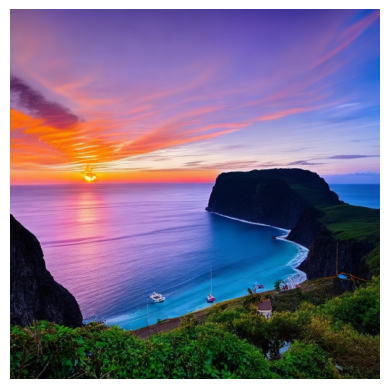

In [5]:
sample = torch.clamp(imgs[0].float()*0.5+0.5, 0, 1).cpu()

plt.imshow(sample.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [10]:
from PIL import Image
im = Image.open('ggbridge.jpg')

(-0.5, 2879.5, 1799.5, -0.5)

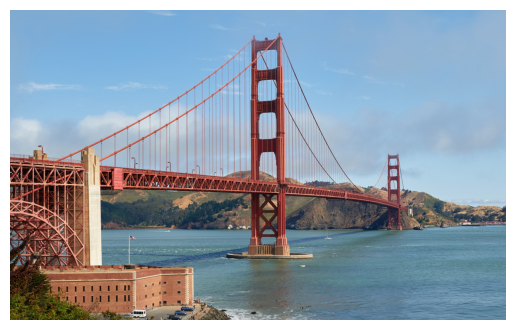

In [7]:
plt.imshow(im)
plt.axis('off')

### Image to text generation (captioning)

In [8]:
dual_diff_pipe.set_sampling_mode('i2t')
dual_diff_pipe(
            image=im,
            prompt=None,
            sequence_length=256,
            num_inference_steps=128,
            resolution=512
        )

"The image captures the iconic Golden Gate Bridge, a renowned landmark in San Francisco, California. The bridge, painted in a striking shade of red, cuts a vivid contrast against the clear blue sky. In the vantage point of the water, the bridge's steel railings and towers, both standing tall. These architectural features are accentuated by the bridge's towering height, with the deep blue water below on which it rests. The bridge spans two parts of the bay, their surface dotted with boats, adding to the grandeur of the structure. The image is taken from a high vantage point, offering a panoramic view of the bridge and the surrounding landscape. In the distance, the tops of buildings and other structures can be spotted, providing a sense of scale and context to the imposing structure that does not pop. The image does not contain any text or discernible actions. The relative positions of the objects suggest a well-composed photograph. The bridge is the central focus, with its towers and t

### Image to text generation (VQA)

In [3]:
dual_diff_pipe = DualDiffSD3Pipeline.from_pretrained("../pretrained_models/dual_diff_sd3_512_sft", torch_dtype=torch.float16).to(device)

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


In [12]:
dual_diff_pipe.set_sampling_mode('i2t')
dual_diff_pipe(
            image=im,
            prompt='Q: Can you identify this landmark? What are some features of this area? A: ',
            sequence_length=128,
            num_inference_steps=32,
            resolution=512
        )

'Q: Can you identify this landmark? What are some features of this area? A: Some of the features can identify this landmark in the image: the iconic Golden Gate Bridge, a long bridge painted in distinctive red color. It elegantly spans across water and forms a unique focus in the image. Additionally, there might be buildings located close to the land, and there is possibly a cityscape with buildings nearby as well, which further contribute to the overall scenery. These landank areas, along with two boats present, contribute to the vibrant and active atmosphere of this scenic destination.'